<a href="https://colab.research.google.com/github/Samjacob007/image-segmentation/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
import skimage.io as io
from tensorflow.keras.utils import to_categorical
import matplotlib.patches as mpatches

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/coco2017/"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001459.jpg  
  inflating: /content/drive/MyDrive/co

In [15]:
train_data_path = "/content/drive/MyDrive/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"

coco = COCO(train_annotation_file)

# ✅ Correct target classes
target_classes = ["cake", "car", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)

# Load categories
categories = coco.loadCats(coco.getCatIds())

# Helper to get class name from ID
def get_category_name(class_ID, categories):
    for cat in categories:
        if cat["id"] == class_ID:
            return cat["name"]
    return "None"

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [14]:
training_images = []
for class_name in target_classes:
    ids = coco.getImgIds(catIds=coco.getCatIds(catNms=[class_name]))
    training_images += coco.loadImgs(ids)

# Remove duplicates
seen = set()
unique_training_images = []
for img in training_images:
    if img["id"] not in seen:
        unique_training_images.append(img)
        seen.add(img["id"])

# Shuffle images
random.seed(0)
random.shuffle(unique_training_images)

In [11]:
# ✅ Filter only images that contain 'car' objects with large area (> 1000 pixels)
filtered_training_images = []

for img in unique_training_images:
    ann_ids = coco.getAnnIds(imgIds=img["id"], catIds=coco.getCatIds(catNms=["car"]))
    anns = coco.loadAnns(ann_ids)

    # Check for any car annotation with area > 1000
    if any(ann['area'] > 1000 for ann in anns):
        filtered_training_images.append(img)

print(f"Filtered images with large 'car' instances: {len(filtered_training_images)}")


Filtered images with large 'car' instances: 224


In [18]:
IMAGE_SIZE = (256, 256)
images, masks = [], []

for img_info in tqdm(filtered_training_images[:200]):

    img_path = os.path.join(train_data_path, 'data', img_info['file_name'])
    image = cv2.imread(img_path)
    if image is None:
        continue
    image = cv2.resize(image, IMAGE_SIZE) / 255.0
    images.append(image)

    ann_ids = coco.getAnnIds(imgIds=img_info["id"], catIds=target_classes_IDs, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)
    for ann in anns:
        name = get_category_name(ann["category_id"], categories)
        if name in target_classes:
            idx = target_classes.index(name) + 1  # background is 0
            mask = np.maximum(coco.annToMask(ann) * idx, mask)

    mask = cv2.resize(mask, IMAGE_SIZE, interpolation=cv2.INTER_NEAREST)
    masks.append(mask)

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.uint8)


100%|██████████| 200/200 [00:04<00:00, 44.08it/s]


In [19]:
NUM_CLASSES = len(target_classes) + 1  # including background
masks_cat = to_categorical(masks, num_classes=NUM_CLASSES)

X_train, X_val, y_train, y_val = train_test_split(images, masks_cat, test_size=0.2, random_state=42)


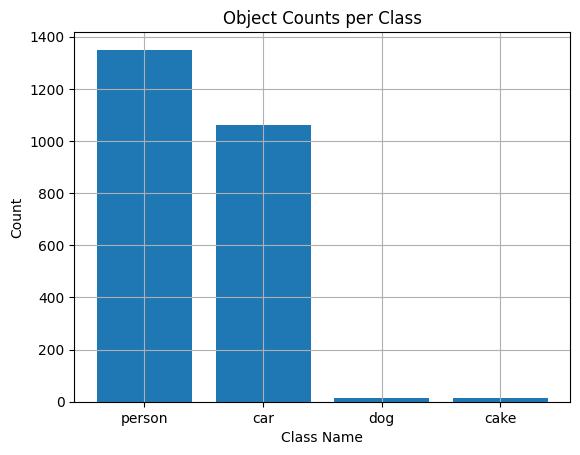

In [20]:
from collections import Counter

class_counts = Counter()
for ann in coco.dataset['annotations']:
    name = get_category_name(ann["category_id"], categories)
    if name in target_classes:
        class_counts[name] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Object Counts per Class")
plt.ylabel("Count")
plt.xlabel("Class Name")
plt.grid(True)
plt.show()

<ipython-input-21-3811090210>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([areas[c] for c in target_classes], labels=target_classes)


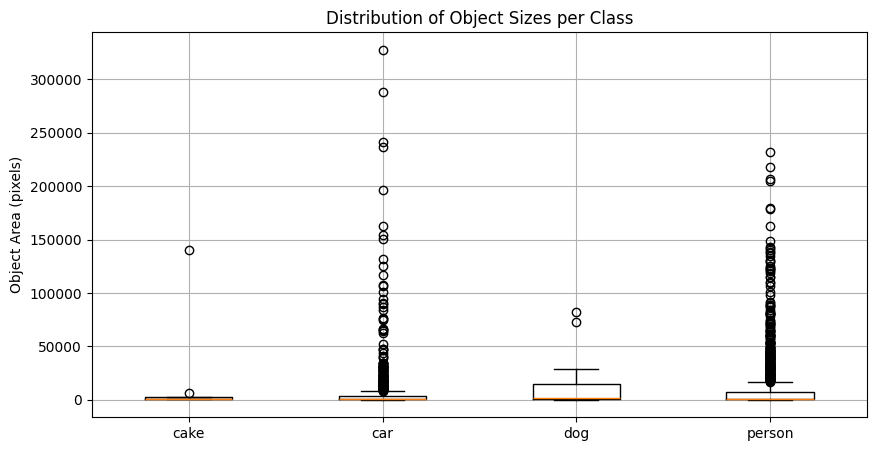

In [21]:
areas = {cls: [] for cls in target_classes}
for ann in coco.dataset['annotations']:
    name = get_category_name(ann["category_id"], categories)
    if name in target_classes:
        areas[name].append(ann['area'])

plt.figure(figsize=(10, 5))
plt.boxplot([areas[c] for c in target_classes], labels=target_classes)
plt.ylabel("Object Area (pixels)")
plt.title("Distribution of Object Sizes per Class")
plt.grid(True)
plt.show()

<ipython-input-22-3997157103>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', NUM_CLASSES)


Saved to sample_visualization_1.png


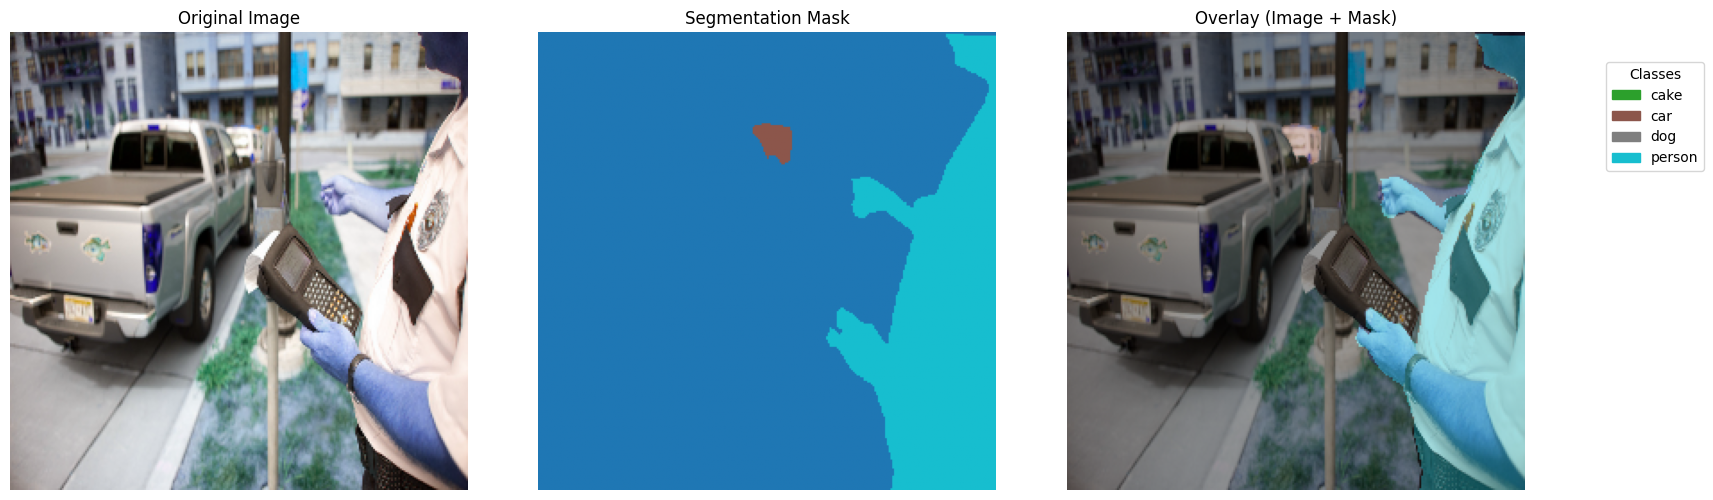

Saved to sample_visualization_2.png


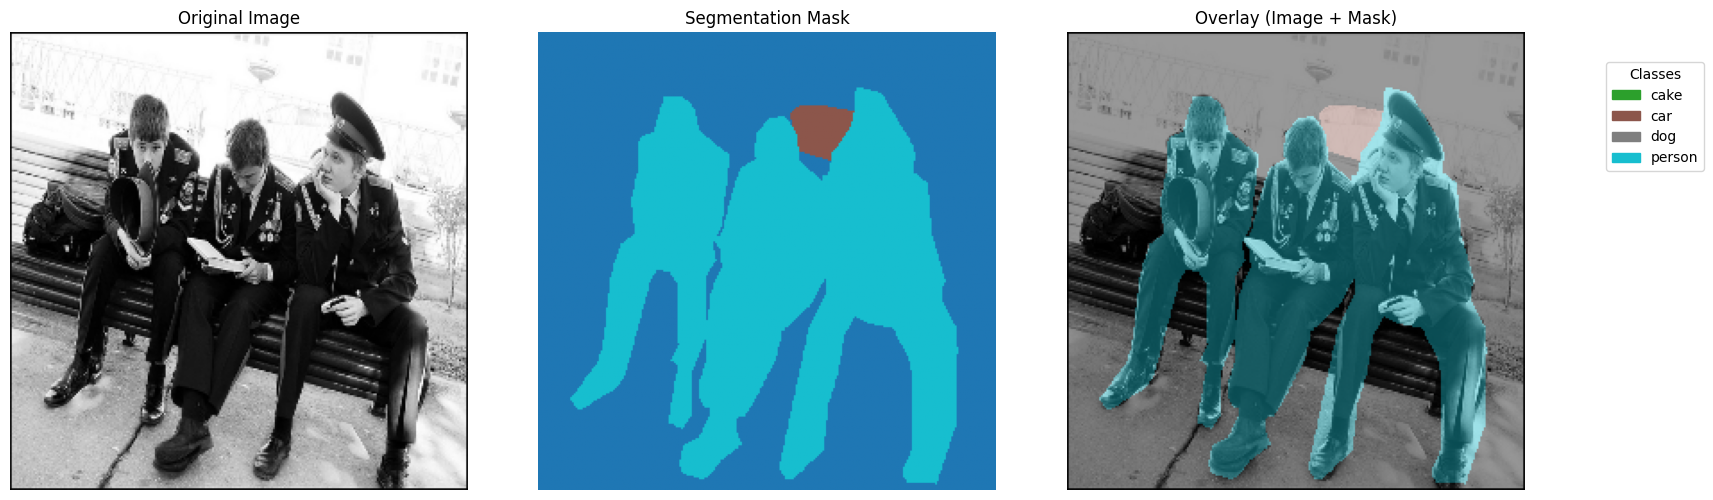

Saved to sample_visualization_3.png


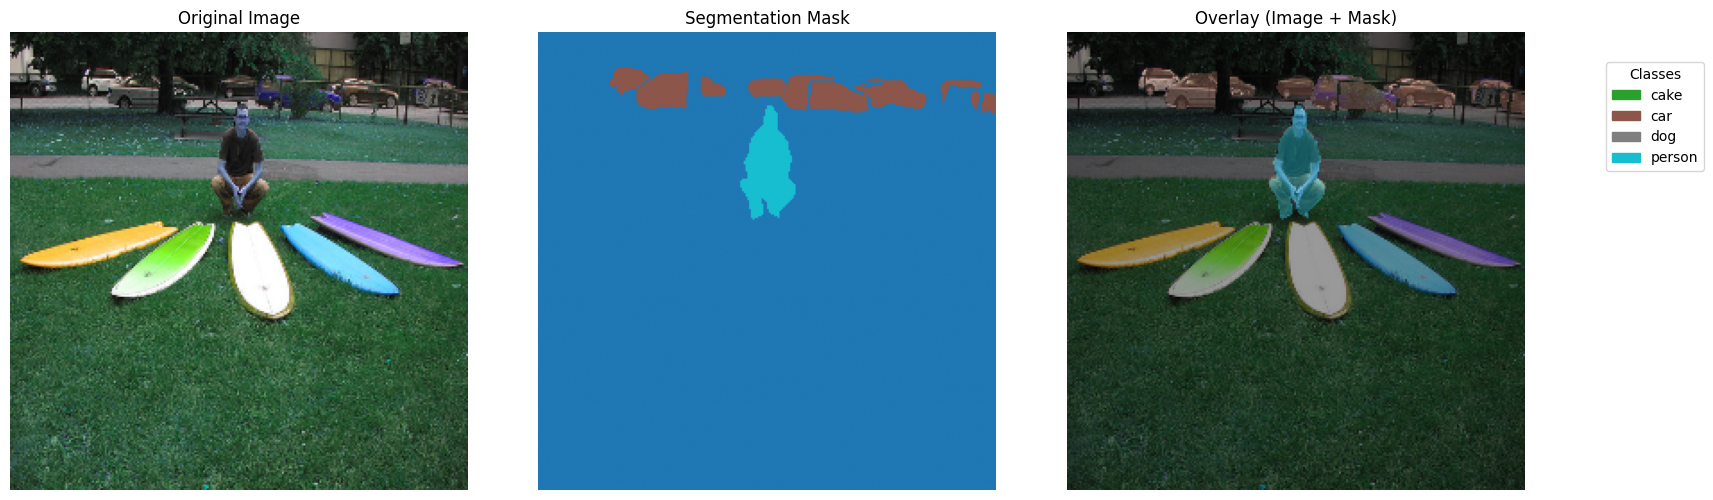


--- Debug: Checking annotations in first 3 images ---

Image 0 (000000007124.jpg):
 - Class: person, Area: 101065.86
 - Class: car, Area: 2255.61

Image 1 (000000004355.jpg):
 - Class: person, Area: 70716.70
 - Class: person, Area: 38410.58
 - Class: car, Area: 745.97

Image 2 (000000000328.jpg):
 - Class: person, Area: 79876.46
 - Class: person, Area: 79865.31
 - Class: person, Area: 106471.66
 - Class: car, Area: 6627.92


In [22]:
def visualize_sample_with_legend(idx, save=False, save_path=None):
    image = images[idx]
    mask = masks[idx]

    # Convert one-hot to categorical if needed
    if len(mask.shape) == 3:
        mask = np.argmax(mask, axis=-1)

    colored_mask = np.zeros_like(image)
    cmap = plt.cm.get_cmap('tab10', NUM_CLASSES)

    for cls in range(1, NUM_CLASSES):  # skip background
        class_color = cmap(cls / NUM_CLASSES)[:3]
        colored_mask[mask == cls] = class_color

    overlay = 0.6 * image + 0.4 * colored_mask

    legend_elements = [
        mpatches.Patch(color=cmap(i / NUM_CLASSES), label=target_classes[i - 1])
        for i in range(1, NUM_CLASSES)
    ]

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
    axs[1].set_title("Segmentation Mask")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay (Image + Mask)")
    axs[2].axis('off')

    fig.legend(handles=legend_elements, bbox_to_anchor=(1.02, 0.9), loc='upper left', title="Classes")

    plt.tight_layout()

    if save and save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved to {save_path}")

    plt.show()

# Show and optionally save 3 sample visualizations
for i in range(3):
    visualize_sample_with_legend(i, save=True, save_path=f"sample_visualization_{i+1}.png")
    # ✅ Debug: Print annotations for the first 3 visualized images
print("\n--- Debug: Checking annotations in first 3 images ---")
for i, img in enumerate(unique_training_images[:3]):
    print(f"\nImage {i} ({img['file_name']}):")
    ann_ids = coco.getAnnIds(imgIds=img["id"], catIds=target_classes_IDs)
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        cls_name = get_category_name(ann['category_id'], categories)
        print(f" - Class: {cls_name}, Area: {ann['area']:.2f}")


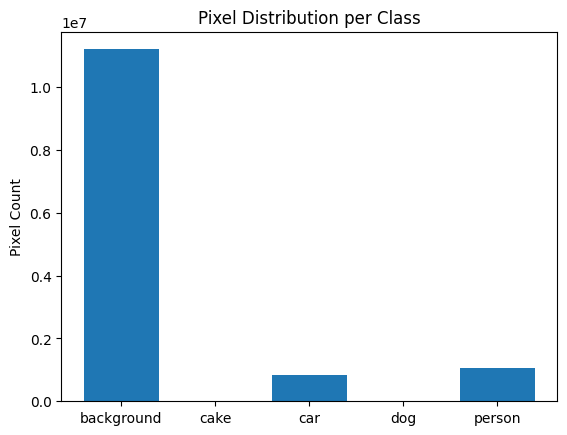

In [25]:
pixel_counts = np.zeros(NUM_CLASSES)

for mask in masks:
    for cls in range(NUM_CLASSES):
        pixel_counts[cls] += np.sum(mask == cls)

plt.bar(range(NUM_CLASSES), pixel_counts)
plt.xticks(range(NUM_CLASSES), ['background'] + target_classes)
plt.title("Pixel Distribution per Class")
plt.ylabel("Pixel Count")
plt.show()


In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_unet(input_shape=(256, 256, 3), num_classes=5):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bridge
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model


In [27]:
model = build_unet(input_shape=(256, 256, 3), num_classes=5)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,032,005 (118.38 MB)

 Trainable params: 31,032,005 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1240s 61s/step - accuracy: 0.7162 - loss: 2.3898 - val_accuracy: 0.8539 - val_loss: 0.5917
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1323s 64s/step - accuracy: 0.8398 - loss: 0.6297 - val_accuracy: 0.8539 - val_loss: 0.5260
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1223s 61s/step - accuracy: 0.8564 - loss: 0.5564 - val_accuracy: 0.8539 - val_loss: 0.5094
Epoch 4/10
 7/20 ━━━━━━━━━━━━━━━━━━━━ 12:15 57s/step - accuracy: 0.8476 - loss: 0.5353